In [1]:
import numpy as np
import math as math
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

In [61]:
from gtda.time_series import TakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
from gtda.diagrams import PairwiseDistance
from sklearn.neighbors import KNeighborsTransformer

def Takens_Embedding(data, parameters_type='search', n_search_samples=10, dim=5, delay=10):
    # In a collection of time series, transforms(Takens Embedding) each time series into a point cloud
    # for further use in TDA methods.
    
    # data - numpy array of the shape (n_samples, L), where L is the length of time series
    # dim - integer, dimension of a each point in point cloud. Used only if parameters_type='fixed'
    # delay - integer, time delay(see Takens Embedding). Used only if parameters_type='fixed'
    # parameters_type - 'search' or 'fixed'. In first case optimal dim and delay are found automatically,
    # In the second case input values are used.
    # n_search samples - number of samples for which optimal dim and delay are found.
    # dim and delay for the whole dataset is then chosen as median values among optimal values, 
    # found for searched samples
    
    # Returns point_clouds - numpy array of the shape (n_samples, n_points, dim)
    # Number of points in each cloud n_points is slightly less than the length of time series(see Takens Embedding)
    
    if parameters_type == 'search':
        L = np.shape(data)[1]
        max_dim = int(math.sqrt(L))
        max_delay = int(math.sqrt(L))
        embedder = TakensEmbedding(parameters_type=parameters_type, 
                                   dimension=max_dim, time_delay=max_delay, n_jobs=-1)
        dim_list = []
        delay_list = []
        for i in range(n_search_samples):
            embedder.fit_transform(data[i])
            dim_list.append(embedder.dimension_)
            delay_list.append(embedder.time_delay_)
        dim = int(np.median(np.array(dim_list)))
        delay = int(np.median(np.array(delay_list)))

    embedder = TakensEmbedding(parameters_type='fixed', dimension=dim, time_delay=delay, n_jobs=-1)
    n_samples = np.shape(data)[0]
    point_clouds = np.array([embedder.fit_transform(data[i]) for i in range(n_samples)])
    return point_clouds

def get_diagrams(point_clouds, dimensions = [0,1]):
    # Calculates persistence diagrams from point clouds. 
    # Complexity of calculation increase with the maximum homology dimension, taken into account
    
    # point_clouds - numpy array of the shape (n_samples, n_points, dim)
    # dimensions - list of integers. 
    
    # Returns diagrams - numpy array of the shape (n_samples, n_features, 3)
    # n_features - total number of topological features, appeared when calculating diagrams.
    # The last axis has the structure [birth_scale, death_scale, homology_dimension]
    
    VR_persistence = VietorisRipsPersistence(homology_dimensions = dimensions)
    diagrams = VR_persistence.fit_transform(point_clouds)
    return diagrams

def get_landscapes(diagrams, n_layers = 5, n_bins = 100):
    # Calculates persistence landscapes from persistent diagrams.
    
    # diagrams - numpy array of the shape (n_samples, n_features, 3)
    # n_layers - integer, number of calculated persistent landscape layers
    # n_bins - integer - number of bins to discretize scale axis
    
    # Returns landscapes - numpy array of the shape (n_samples, homolgy_dimensions, n_layers, n_bins)
    
    Persistence_Landscape = PersistenceLandscape(n_layers = n_layers, n_bins = n_bins)
    landscapes = Persistence_Landscape.fit_transform(diagrams)
    return landscapes

def get_kNN_score(diagrams, labels, n_neighbours=5, n_layers=1, n_bins=100):
    # Calculates kNN score for collection of diagrams, obtained from original collection of time series.
    # The score shows how the collection of persistent landscapes, corresponding to each label,
    # are separeted from each other, in the sense of L2 distance in the Hilbert space of persistent landscape
    # Important! takes as input persistent diagrams, not landscapes
    
    # diagrams - numpy array of the shape (n_samples, n_features, 3)
    # labels - numpy array of the shape (n_samples)
    # n_neighbours - integer, number of nearest used to calculate the score
    # n_layers - number of persistent landscape layers, taken into account
    # n_bins - discritization of scale axis, used to calculate persistent landscape
    
    # returns kNN_score - real number between 0 and 1
    
    n_samples = np.shape(diagrams)[0]
    diagram_distances = PairwiseDistance(metric='landscape', 
                                     metric_params={'p':2, 'n_bins':100, 'n_layers':n_layers})
    pairwise_distances = diagram_distances.fit_transform(diagrams)
    kNN_transformer = KNeighborsTransformer(mode='connectivity', metric='precomputed', n_neighbors=n_neighbours)
    connectivity_matrix = kNN_transformer.fit_transform(pairwise_distances).toarray()
    matching_matrix = labels[:, np.newaxis] == labels[np.newaxis, :]
    kNN_score = (np.sum(matching_matrix * connectivity_matrix) - n_samples) / (np.sum(connectivity_matrix) - n_samples)
    return kNN_score

In [286]:
import torch

def Takens_Embedding_torch(data, d=5, delay=10):
    # In a collection of time series, transforms(Takens Embedding) each time series into a point cloud
    # for further use in TDA methods.
    
    # data - torch tensor of the shape (n_samples, L, internal_dim), where L is the length of time series
    # internal_dim - dimenssion of time series data(equal to 1 for univariate time series)
    # d - integer, determines dimension of points in point cloud: d * internal_dim. 
    # delay - integer, time delay.
    
    # Returns point_clouds - pytorch tensor of the shape (n_samples, n_points, d * internal_dim)
    # Number of points in each cloud n_points = L - delay * (d - 1)
    
    n_samples, L, internal_dim = data.size()

    point_clouds = torch.cat(
        tuple([torch.cat((data[:, (i*delay):, :], torch.zeros(n_samples, i*delay, internal_dim)), dim=1)
                      for i in range(d)]), dim=2)
    n_points = L - delay * (d-1)
    point_clouds = point_clouds[:, :n_points, :]
    
    return point_clouds

def get_diagrams_torch(point_clouds, maxdim = 1):
    # Calculates persistence diagrams from point clouds. 
    # Complexity of calculation increase with the maximum homology dimension, taken into account
    
    # point_clouds -  pytorch tensor of the shape (n_samples, n_points, dim)
    # maxdim - maximum homology dimension 
    
    # Returns tuple (diagrams_torch, diagrams_np, VR_persistence)
    #diagrams_torch - pytorch tensors of the shape (n_samples, maxdim + 1, n_features, 2)
    # n_features - maximum number of topological features, across different samples.
    # The last axis has the structure [birth_scale, death_scale]
    # The last two elements in tuple are needed for plotting diagrams only
    
    homology_dimensions = tuple(range(maxdim + 1))
    VR_persistence = VietorisRipsPersistence(homology_dimensions = homology_dimensions)
    point_clouds_np = point_clouds.numpy()
    diagrams_np = VR_persistence.fit_transform(point_clouds_np)
    homology_dimensions = diagrams_np[:, :, 2, np.newaxis]
    diagrams_torch = []
    for i in range(maxdim + 1):
        diagrams_fixed_Hdim = np.select([homology_dimensions == i], [diagrams_np[:, :, :2]])
        diagrams_torch.append(torch.FloatTensor(diagrams_fixed_Hdim[:, np.newaxis, :, :]))
    diagrams_torch = torch.cat(tuple(diagrams_torch), dim=1)
    return diagrams_torch, diagrams_np, VR_persistence

def relu(x, a=0.):
    return torch.max(x-a, torch.full_like(x, 0))

def get_landscapes_torch(diagrams, n_layers=10, n_steps=100):
    
    # diagrams - torch tensor of the shape(n_samples, maxdim + 1, n_features, 2)
    # returns:
    # landscapes_final - torch tensor of the shape(n_samples, maxdim + 1, n_layers, n_steps)
    # max_scale - maximum scale value at which at least one persistent landscapes is non-zero
    
    n_samples, n_hdim, n_features, temp = diagrams.size() 
    scale_min = 0
    scale_max = torch.max(diagrams[:, :, :, 1])
    lin_plus = torch.linspace(scale_min, scale_max, n_steps)
    lin_plus = lin_plus[None, None, None, :].expand(n_samples, n_hdim, n_features, -1)
    relu_plus = relu(lin_plus - diagrams[:, :, :, 0, None])
    relu_minus = relu(-lin_plus + diagrams[:, :, :, 1, None])
    landscapes_individual = torch.min(relu_plus, relu_minus)
    landscapes_final, indices = torch.sort(landscapes_individual, dim=2, descending=True)
    landscapes_final = landscapes_final[:, :, :n_layers, :]
    return landscapes_final, scale_max

def landscapes_distances(landscapes, max_scale, n_layers=1):
    
    # landscapes - torch tensor of the shape(n_samples, maxdim + 1, n_layers, n_steps)
    # returns pairwise_distances - torch tensor of the shape(n_samples, n_samples),
    # containing pairwise distances(L2 persistent landscape distance) between samples in dataset 
    landscapes_reduced = landscapes[:, :, :n_layers, :]
    n_samples, n_hdim, n_layers, n_steps = landscapes_reduced.size()
    landscapes_1 = landscapes_reduced[:, None, :, :, :]
    landscapes_2 = landscapes_reduced[None, :, :, :, :]
    pairwise_distances = torch.sum((landscapes_1 - landscapes_2) ** 2, [2,3,4])
    pairwise_distances = (max_scale / n_steps * pairwise_distances) ** 0.5
    return pairwise_distances
    
def get_kNN_score_torch(pairwise_distances, matching_matrix, n_neighbours=5):

    # The score shows how the collection of persistent landscapes, corresponding to each label,
    # are separeted from each other, in the sense of L2 distance in the Hilbert space of persistent landscape
    
    # pairwise_distances - torch tensor of the shape (n_samples, n_samples). 
    # mathcing_matrix - numpy array of the shape (n_samples, n_samples). 1 if samples have the same label, 0 otherwise
    # n_neighbours - integer, number of nearest used to calculate the score
    
    # returns kNN_score - real number between 0 and 1
    
    n_samples = pairwise_distances.size()[0]
    kNN_transformer = KNeighborsTransformer(mode='connectivity', metric='precomputed', n_neighbors=n_neighbours)
    connectivity_matrix = kNN_transformer.fit_transform(pairwise_distances.numpy()).toarray()
    #if(matching_matrix == 0):
    #    matching_matrix = labels.numpy()[:, np.newaxis] == labels.numpy()[np.newaxis, :]
    kNN_score = (np.sum(matching_matrix * connectivity_matrix) - n_samples) / (np.sum(connectivity_matrix) - n_samples)
    return kNN_score

# Augmentation in Time Series

## Data Loading

In [3]:
# Install and import of https://pypi.org/project/uea-ucr-datasets/
![ -z "$(pip list | grep 'Cython')" ] && pip install Cython
![ -z "$(pip list | grep 'uea-ucr-datasets')" ] && pip install uea-ucr-datasets

Path('./data').mkdir(exist_ok=True)
%env UEA_UCR_DATA_DIR={Path.cwd()}/data
import uea_ucr_datasets as ucr_ds

env: UEA_UCR_DATA_DIR=/home/yellow/courses/Machine Learning/project/data


In [4]:
# Download univariate dataset (preprocessed by sktime)
url = ('http://www.timeseriesclassification.com/'
       'Downloads/Archives/Univariate2018_ts.zip')
try:
    is_empty = not any(Path('./data').iterdir())
except FileNotFoundError:
    is_empty = True
if is_empty:
    !wget -O data/archive.zip {url}

In [5]:
# Extract files from the archive
!unzip -qn ./data/archive.zip -d data
!mv -n data/Univariate_ts/* data
!rmdir data/Univariate_ts 2> /dev/null
# Output some folder names below
!ls ./data | head -10

ACSF1
Adiac
AllGestureWiimoteX
AllGestureWiimoteY
AllGestureWiimoteZ
archive.zip
ArrowHead
Beef
BeetleFly
BirdChicken


In [6]:
# This is how a raw file looks
!cat data/Coffee/Coffee_TRAIN.ts

# As we can see, it wouldn't be a problem
# for us to process the data ourselves

#"FoodFood spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The coffee data set is a two class problem to distinguish between Robusta and Aribica coffee beans. Further information can be found in the original paper Briandet et al. Discrimination of Arabica and Robusta in Instant Coffee by Fourier Transform Infrared Spectroscopy and Chemometrics J. Agricultural and Food Chemistry, 44 (1), 1996. The data was first used in the time series classification literature in Bagnall et al. Transformation Based Ensembles for Time Series Classification, SDM 2012.
@problemName Coffee
@timeStamps false
@missing false
@univariate true
@equalLength true
@seriesLength 286
@classLabel true 0 1
@data
-0.51841899,-0.48588363,-0.50500747,-0.56018294,-0.63629941,-0.75322902,-0.82722915,-0.85976467,-0.90632072,-0.92379648,-0.93321222,-0.93442926,-0.92078716,-0.93657191,-0.95599685,-0.95934101,-0.96940599,-0.9824055,-0.976

## Coffee dataset

In [7]:
coffee_ds = ucr_ds.Dataset('Coffee', train=True)
data_x=coffee_ds.data_x
data_y=coffee_ds.data_y
data_x = data_x.to_numpy()
L = data_x[0][0].count()
n_samples = np.shape(data_x)[0]
data_x = np.array([sample[0].to_list() for sample in data_x])
print(np.shape(data_x), np.shape(data_y))

(28, 286) (28,)


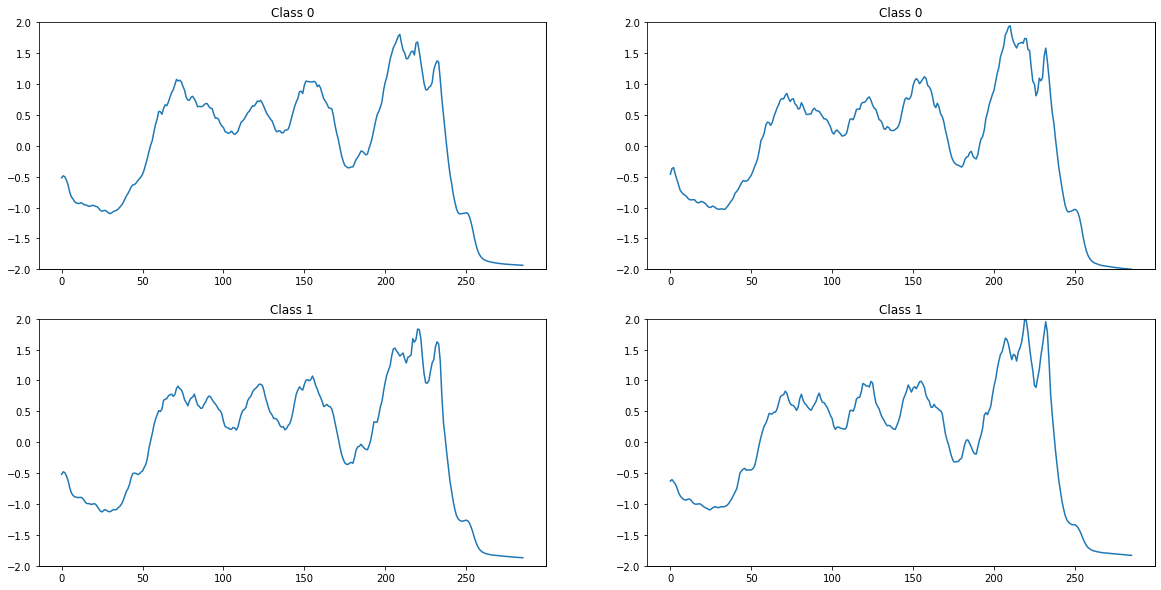

In [8]:
#Plot a couple of representatives from each class
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(20,10))
for i in range(4):
    ax[i // 2][i % 2].set_xticks([])
    ax[i // 2][i % 2].set_yticks([])
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_ylim(-2.0, 2.0)
    ax.set_title("Class {}".format(data_y[i*7]))
    ax.plot(np.arange(L),data_x[i*7])
plt.show()

In [19]:
from gtda.plotting import plot_point_cloud

point_clouds = Takens_Embedding(data_x)
diagrams = get_diagrams(point_clouds)
landscapes = get_landscapes(diagrams)
print("Point_clouds shape: ", np.shape(point_clouds))
print("Diagrams shape: ", np.shape(diagrams))
print("Landscapes shape: ", np.shape(landscapes))

Point_clouds shape:  (28, 154, 12)
Diagrams shape:  (28, 157, 3)
Landscapes shape:  (28, 2, 5, 100)


In [26]:
from gtda.plotting import plot_point_cloud

#Let's visualize results
print('point cloud for first time series in dataset: ')
plot_point_cloud(point_clouds[0],dimension=3)

VR_persistence = VietorisRipsPersistence(homology_dimensions = [0,1,2])
print('persistent diagram for first time series in dataset: ')
VR_persistence.plot(diagrams, sample = 0)

Persistence_Landscape = PersistenceLandscape(n_layers = 50, n_bins = 100)
Persistence_Landscape.fit(diagrams)
print('persistent landscape for first time series in dataset: ')
Persistence_Landscape.plot(landscapes, sample=0, homology_dimensions=(0,1))


point cloud for first time series in dataset: 


persistent diagram for first time series in dataset: 


persistent landscapefor first time series in dataset: 


In [288]:
data_torch = torch.FloatTensor(data_x)[:, :, None]

point_clouds_torch = Takens_Embedding_torch(data_torch, d=5, delay=10)

diagrams_torch, diagrams_np, VR_persistence = get_diagrams_torch(point_clouds_torch)

landscapes_torch, max_scale = get_landscapes_torch(diagrams_torch, n_layers=10)

pairwise_distances = landscapes_distances(landscapes_torch, max_scale)
matching_matrix = data_y[:, np.newaxis] == data_y[np.newaxis, :]

kNN_score = get_kNN_score_torch(pairwise_distances, matching_matrix=matching_matrix)
print("Point_clouds shape: ", point_clouds_torch.size())
print("Diagrams shape: ", diagrams_torch.size())
print("Landscapes shape: ", landscapes_torch.size())
print("kNN score: ", kNN_score)

Point_clouds shape:  torch.Size([28, 246, 5])
Diagrams shape:  torch.Size([28, 2, 270, 2])
Landscapes shape:  torch.Size([28, 2, 10, 100])
kNN score:  0.7767857142857143


In [ ]:
from gtda.plotting import plot_point_cloud

#Let's visualize results
print('point cloud for first time series in dataset: ')
plot_point_cloud(point_clouds[0],dimension=3)

VR_persistence = VietorisRipsPersistence(homology_dimensions = [0,1,2])
print('persistent diagram for first time series in dataset: ')
VR_persistence.plot(diagrams, sample = 0)

Persistence_Landscape = PersistenceLandscape(n_layers = 50, n_bins = 100)
Persistence_Landscape.fit(diagrams)
print('persistent landscape for first time series in dataset: ')
Persistence_Landscape.plot(landscapes, sample=0, homology_dimensions=(0,1))


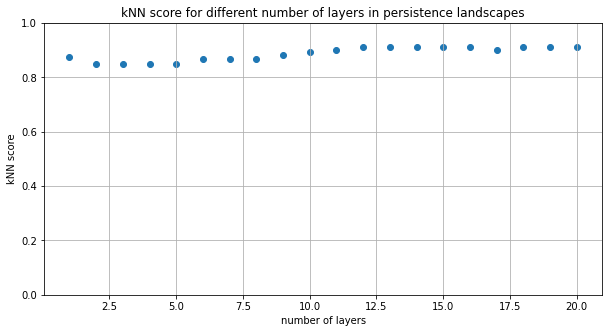

In [36]:
n_samples = np.shape(data_x)[0]
kNN_score_list = []
for i in range(20):
    kNN_score = get_kNN_score(diagrams, data_y, n_layers=(i+1))
    kNN_score_list.append(kNN_score)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
x = np.arange(20) + 1
ax.scatter(x, kNN_score_list)
ax.set_ylim([0,1])
ax.grid()
ax.set_title('kNN score for different number of layers in persistence landscapes')
ax.set_xlabel("number of layers")
ax.set_ylabel("kNN score")
plt.show()    

In [67]:

L = np.shape(data_x)[1]
kNN_scores = np.zeros((L, L))
for time_delay in range(1, L // 2):
    for dim in range(1, L // time_delay):
        point_clouds = Takens_Embedding(data_x, parameters_type='fixed', delay=time_delay, dim=dim)
        diagrams = get_diagrams(point_clouds)
        kNN_scores[dim - 1, time_delay - 1] = get_kNN_score(diagrams, data_y, n_neighbours=5)
        print("({}, {}, {})".format(dim, time_delay, kNN_scores[dim - 1, time_delay - 1]), end=' ')

(1, 1, 0.49107142857142855) (2, 1, 0.7321428571428571) (3, 1, 0.9107142857142857) (4, 1, 0.9732142857142857) (5, 1, 0.9732142857142857) (6, 1, 0.9732142857142857) (7, 1, 0.9910714285714286) (8, 1, 0.9910714285714286) (9, 1, 0.9821428571428571) (10, 1, 1.0) (11, 1, 0.9821428571428571) (12, 1, 0.9464285714285714) (13, 1, 0.9375) (14, 1, 0.8928571428571429) (15, 1, 0.8660714285714286) (16, 1, 0.8660714285714286) (17, 1, 0.9196428571428571) (18, 1, 0.8571428571428571) (19, 1, 0.8392857142857143) (20, 1, 0.8214285714285714) (21, 1, 0.8303571428571429) (22, 1, 0.8303571428571429) (23, 1, 0.8482142857142857) (24, 1, 0.875) (25, 1, 0.8482142857142857) (26, 1, 0.8482142857142857) (27, 1, 0.8482142857142857) (28, 1, 0.8482142857142857) (29, 1, 0.8571428571428571) (30, 1, 0.8660714285714286) (31, 1, 0.8482142857142857) (32, 1, 0.8571428571428571) (33, 1, 0.8660714285714286) (34, 1, 0.8214285714285714) (35, 1, 0.7946428571428571) (36, 1, 0.8125) (37, 1, 0.7410714285714286) (38, 1, 0.74107142857142

(14, 2, 0.8571428571428571) (15, 2, 0.8660714285714286) (16, 2, 0.8571428571428571) (17, 2, 0.8214285714285714) (18, 2, 0.7678571428571429) (19, 2, 0.7232142857142857) (20, 2, 0.6875) (21, 2, 0.6875) (22, 2, 0.6875) (23, 2, 0.7142857142857143) (24, 2, 0.7053571428571429) (25, 2, 0.75) (26, 2, 0.7678571428571429) (27, 2, 0.8125) (28, 2, 0.8660714285714286) (29, 2, 0.8928571428571429) (30, 2, 0.9196428571428571) (31, 2, 0.9375) (32, 2, 0.8928571428571429) (33, 2, 0.875) (34, 2, 0.8125) (35, 2, 0.7857142857142857) (36, 2, 0.7589285714285714) (37, 2, 0.7946428571428571) (38, 2, 0.875) (39, 2, 0.8928571428571429) (40, 2, 0.8839285714285714) (41, 2, 0.8839285714285714) (42, 2, 0.875) (43, 2, 0.8839285714285714) (44, 2, 0.875) (45, 2, 0.8928571428571429) (46, 2, 0.8571428571428571) (47, 2, 0.8392857142857143) (48, 2, 0.8303571428571429) (49, 2, 0.7946428571428571) (50, 2, 0.7857142857142857) (51, 2, 0.8303571428571429) (52, 2, 0.8125) (53, 2, 0.8392857142857143) (54, 2, 0.8928571428571429) (5

(22, 5, 0.9196428571428571) (23, 5, 0.9017857142857143) (24, 5, 0.8660714285714286) (25, 5, 0.8392857142857143) (26, 5, 0.8571428571428571) (27, 5, 0.9017857142857143) (28, 5, 0.9196428571428571) (29, 5, 0.9375) (30, 5, 0.9285714285714286) (31, 5, 0.8928571428571429) (32, 5, 0.8928571428571429) (33, 5, 0.875) (34, 5, 0.8839285714285714) (35, 5, 0.875) (36, 5, 0.8214285714285714) (37, 5, 0.8303571428571429) (38, 5, 0.8392857142857143) (39, 5, 0.8125) (40, 5, 0.8035714285714286) (41, 5, 0.8303571428571429) (42, 5, 0.8214285714285714) (43, 5, 0.8303571428571429) (44, 5, 0.8303571428571429) (45, 5, 0.8303571428571429) (46, 5, 0.8303571428571429) (47, 5, 0.8303571428571429) (48, 5, 0.8214285714285714) (49, 5, 0.8392857142857143) (50, 5, 0.8214285714285714) (51, 5, 0.8392857142857143) (52, 5, 0.8482142857142857) (53, 5, 0.8482142857142857) (54, 5, 0.8482142857142857) (55, 5, 0.8482142857142857) (56, 5, 0.8482142857142857) (1, 6, 0.49107142857142855) (2, 6, 1.0) (3, 6, 0.8303571428571429) (4,

(4, 16, 0.7678571428571429) (5, 16, 0.8660714285714286) (6, 16, 0.9196428571428571) (7, 16, 0.875) (8, 16, 0.8482142857142857) (9, 16, 0.9196428571428571) (10, 16, 0.8660714285714286) (11, 16, 0.8839285714285714) (12, 16, 0.875) (13, 16, 0.8839285714285714) (14, 16, 0.8660714285714286) (15, 16, 0.8660714285714286) (16, 16, 0.8571428571428571) (1, 17, 0.49107142857142855) (2, 17, 0.9017857142857143) (3, 17, 0.875) (4, 17, 0.8125) (5, 17, 0.875) (6, 17, 0.9464285714285714) (7, 17, 0.9553571428571429) (8, 17, 0.9375) (9, 17, 0.9017857142857143) (10, 17, 0.8660714285714286) (11, 17, 0.8482142857142857) (12, 17, 0.8660714285714286) (13, 17, 0.8660714285714286) (14, 17, 0.8660714285714286) (15, 17, 0.8660714285714286) (1, 18, 0.49107142857142855) (2, 18, 0.8482142857142857) (3, 18, 0.8214285714285714) (4, 18, 0.8303571428571429) (5, 18, 0.9107142857142857) (6, 18, 0.8928571428571429) (7, 18, 0.9285714285714286) (8, 18, 0.8839285714285714) (9, 18, 0.9375) (10, 18, 0.9107142857142857) (11, 18,

(1, 59, 0.49107142857142855) (2, 59, 0.8839285714285714) (3, 59, 0.8035714285714286) (1, 60, 0.49107142857142855) (2, 60, 0.9285714285714286) (3, 60, 0.8482142857142857) (1, 61, 0.49107142857142855) (2, 61, 0.8482142857142857) (3, 61, 0.8303571428571429) (1, 62, 0.49107142857142855) (2, 62, 0.7678571428571429) (3, 62, 0.7321428571428571) (1, 63, 0.49107142857142855) (2, 63, 0.6875) (3, 63, 0.8839285714285714) (1, 64, 0.49107142857142855) (2, 64, 0.7589285714285714) (3, 64, 0.9017857142857143) (1, 65, 0.49107142857142855) (2, 65, 0.6875) (3, 65, 0.9107142857142857) (1, 66, 0.49107142857142855) (2, 66, 0.6517857142857143) (3, 66, 0.9017857142857143) (1, 67, 0.49107142857142855) (2, 67, 0.6428571428571429) (3, 67, 0.7857142857142857) (1, 68, 0.49107142857142855) (2, 68, 0.5357142857142857) (3, 68, 0.7410714285714286) (1, 69, 0.49107142857142855) (2, 69, 0.8125) (3, 69, 0.7142857142857143) (1, 70, 0.49107142857142855) (2, 70, 0.8214285714285714) (3, 70, 0.7232142857142857) (1, 71, 0.491071

In [79]:
np.argmax(kNN_scores, axis = 0)

array([ 9,  3,  2,  1,  1,  1,  1,  1,  1,  7,  6,  6,  6,  5, 13,  5,  6,
       11,  4,  7,  6,  4,  8,  4,  3,  5,  5,  5,  2,  7,  2,  2,  3,  5,
        3,  3,  3,  2,  2,  2,  3,  3,  3,  3,  4,  3,  4,  1,  3,  2,  3,
        3,  1,  2,  3,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        1,  1,  2,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [289]:
time_delay = 10
dim = 5
point_clouds = Takens_Embedding(data_x, parameters_type='fixed', delay=time_delay, dim=dim)
diagrams = get_diagrams(point_clouds)
score = kNN_scores[dim - 2, time_delay - 2] = get_kNN_score(diagrams, data_y, n_neighbours=5)
print("({}, {}, {})".format(dim, time_delay, score))

(5, 10, 0.7767857142857143)
